## Trabajo Práctico AA2 - 2024 C2
### Integrantes:
  - Alomar, Francisco
  - Arce, Sofía

- Descripción: En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.

- Dataset: https://www.tensorflow.org/datasets/catalog/xtreme_s incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.

- Objetivo: Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.

Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

# Librerías

In [6]:
!pip install tensorflow

In [7]:
!pip install pydub

In [9]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from typing import Optional
from tensorflow_datasets.core import dataset_info # de aca viene el dataset

# Construcción y carga del Dataset


In [10]:
tfds.builder('xtreme_s').info # full_name

tfds.core.DatasetInfo(
    name='xtreme_s',
    full_name='xtreme_s/fleurs.af_za/2.0.0',
    description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    XTREME-S covers four task families: speech recognition, classification, speech-to-text translation and retrieval. Covering 102
    languages from 10+ language families, 3 different domains and 4
    task families, XTREME-S aims to simplify multilingual speech
    representation evaluation, as well as catalyze research in “universal” speech representation learning.
    
    In this version, only the FLEURS dataset is provided, which covers speech
    recognition and speech-to-text translation.
    """,
    config_description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    """,
    homepage='https://arxiv.org/abs/2205.12446',
    data_dir=PosixGPa

In [12]:
#!rm -rf data

In [11]:
DATASET_PATH = 'data'

data_dir = pathlib.Path(DATASET_PATH)
lan = {'español':'es_419', 'ingles': 'en_us', 'frances':'fr_fr', 'japones': 'ja_jp'}

In [20]:
#for key, value in lan.items():
#    # Traigo solamente una parte del subset de test para agilizar la carga
#    tfds.load(f'xtreme_s/fleurs.{value}', split='test[:1%]', shuffle_files=False, data_dir=data_dir / key)
#
#    # Limpiar y quedarme unicamente con los audios que me insteresan
#    !mv data/{key}/TAR_GZ*/ data/{key}/TAR_GZ_rename
#    !mv data/{key}/TAR_GZ_rename/{value}/audio/* data/{key}
#    !rm -rf data/{key}/TAR_GZ_rename



In [13]:
df = '/content/data'
data_dir = pathlib.Path(df)

# Distribuciones de las clases


In [186]:
import os
for dir in os.listdir(df):
    print(f'{dir}: {len(os.listdir(os.path.join(df, dir, "train")))}')

frances: 3193
ingles: 2602
japones: 2292
español: 2796


Las clases no estan balanceadas. Continuaremos sin balancear mis clases y evaluar los resultados.

# Analisis Exploratorio


In [15]:
!pip install librosa
import librosa
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
import os

Documentacion de tensorflow: tf.audio.decode_wav, only 16-bit PCM WAV es soportado por este método, entonces rescribimos los audios que no estén en este formato: https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav

In [16]:
for dir in os.listdir(df):
  for env in ['train', 'dev', 'test']:
    current_dir_path = os.path.join(df, dir, env)
    for wav in os.listdir(current_dir_path):
        if wav.endswith(".wav"):
            wav_path = os.path.join(current_dir_path, wav)

            # Load audio with librosa and resample if necessary
            audio_data, sample_rate = librosa.load(wav_path, sr=None)  # sr=None to keep original sample rate

            # Convert to 16-bit PCM if needed
            if audio_data.dtype != 'int16':
                audio_data = (audio_data * 32767).astype('int16')  # Scale to int16 range
                sf.write(wav_path, audio_data, sample_rate, subtype='PCM_16')  # Overwrite with 16-bit PCM

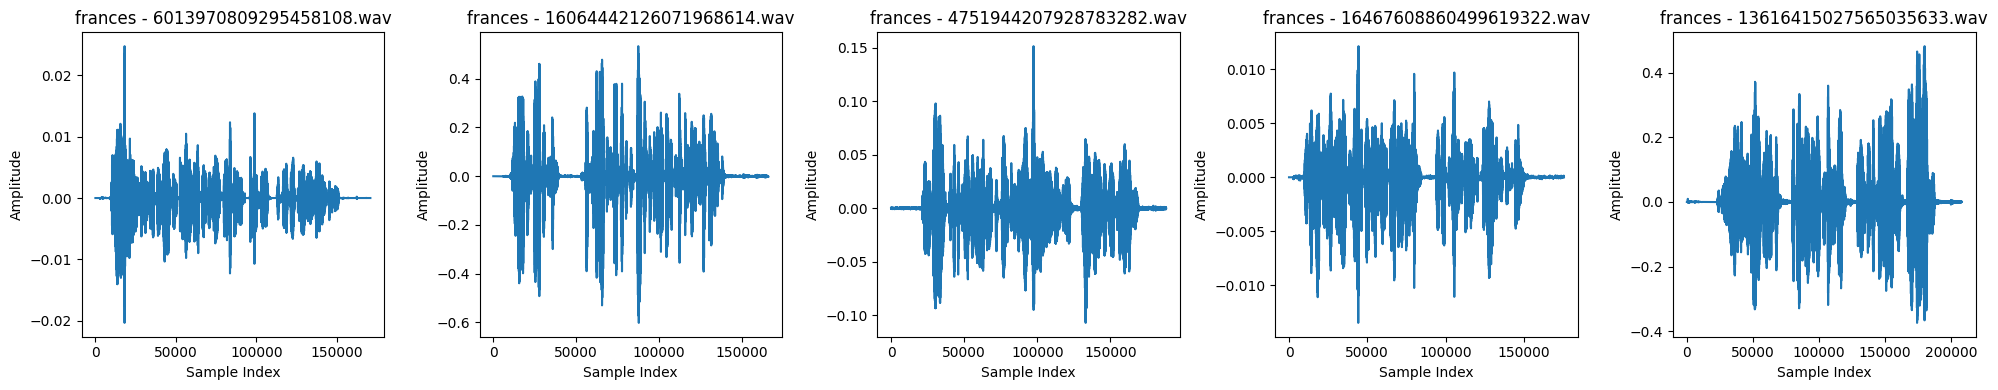

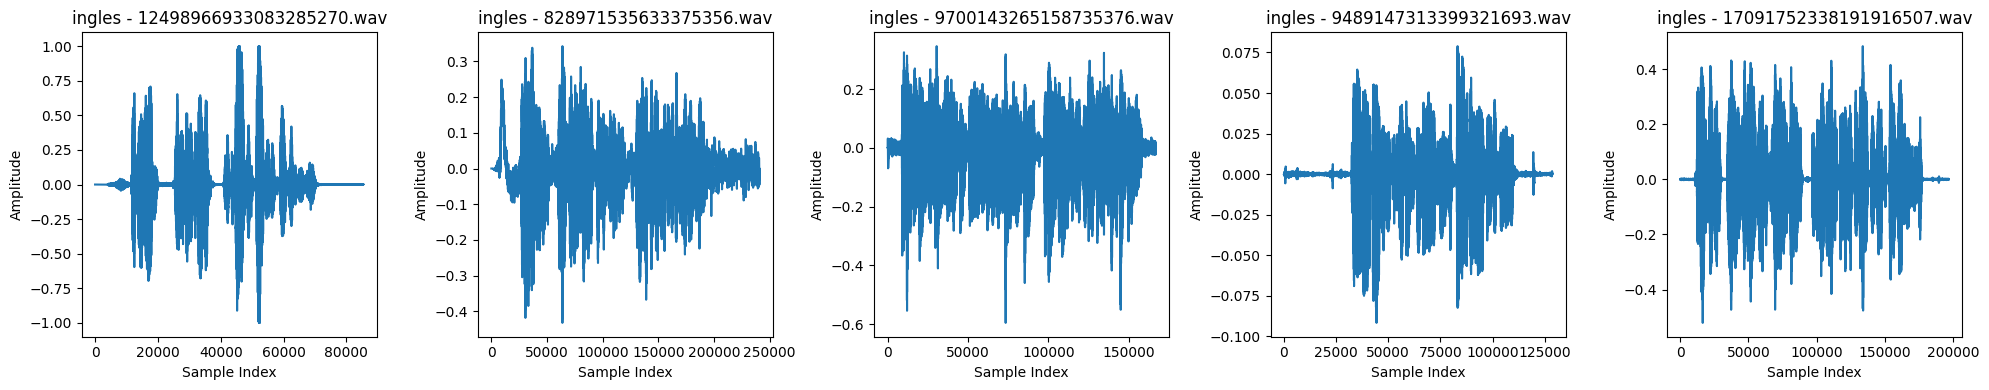

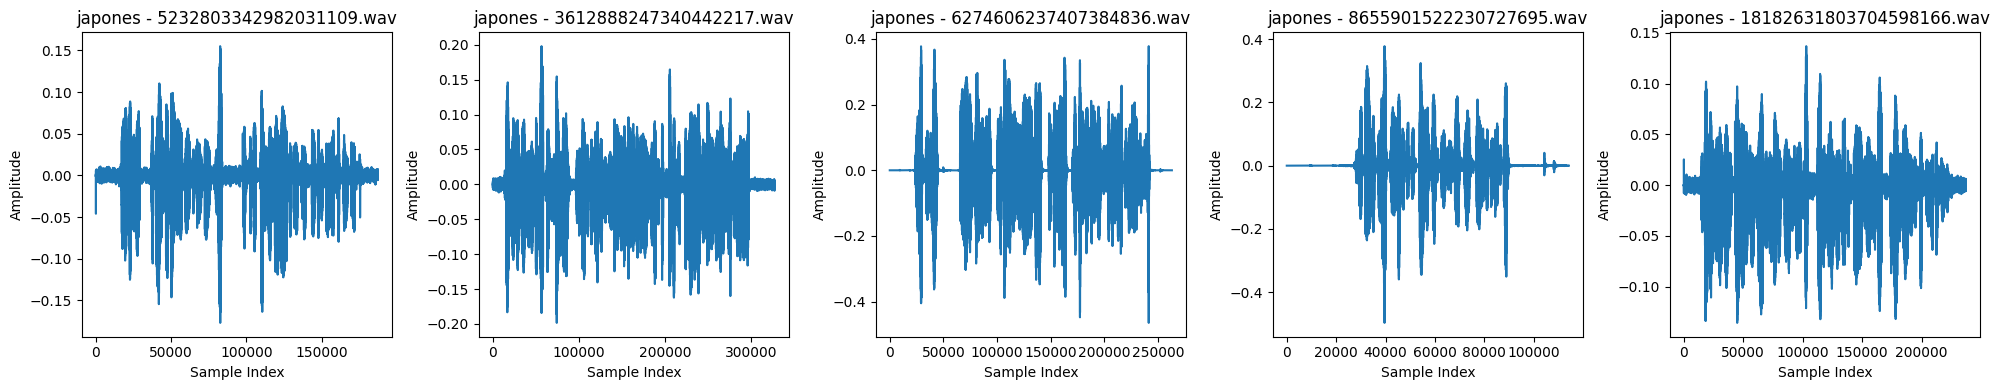

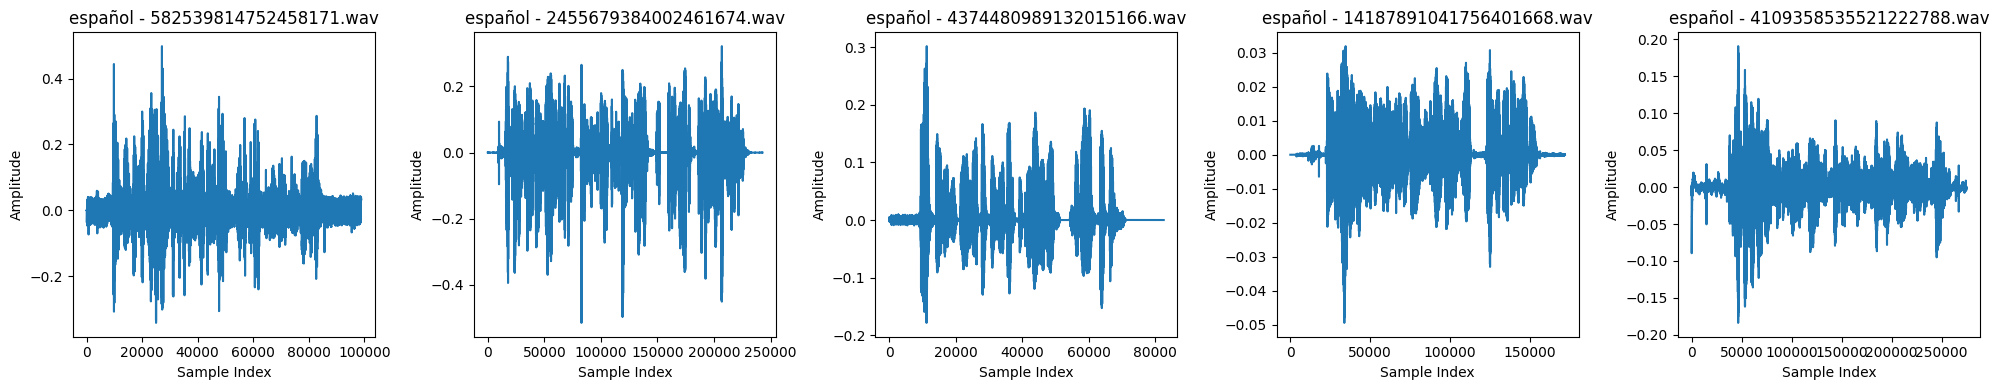

In [17]:
for dir in os.listdir(df):
    current_dir_path = os.path.join(df, dir, 'train')
    plt.figure(figsize=(20, 4))

    count = 1

    for wav in os.listdir(current_dir_path):
        if wav.endswith(".wav"):
            wav_path = os.path.join(current_dir_path, wav)
            # Decode using tf.audio.decode_wav
            audio = tf.audio.decode_wav(tf.io.read_file(wav_path))

            plt.subplot(1, 5, count)
            plt.plot(audio.audio.numpy()) # Use audio.audio to access the audio data
            plt.title(f'{dir} - {wav}')
            plt.xlabel('Sample Index')
            plt.ylabel('Amplitude')

            count += 1
            if count > 5:
                break

    plt.tight_layout()
    plt.show()

Segun los los primeros 5 wav files de cada idioma, la longitud de los audios varían entre 10kHz y 30kHz vemos la dimension de los audios.

In [18]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=160000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 15121 files belonging to 4 classes.
Using 12097 files for training.
Using 3024 files for validation.

label names: ['español' 'frances' 'ingles' 'japones']


In [19]:
train_ds.element_spec

(TensorSpec(shape=(None, 160000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

**shape=(None, 160000, None)**
  - Batch Size: No tiene
  - Audio Samples: No seteamos nigun output_sequence_length, por lo que a las secuencias del mismo bache se les agregó padding de la longitud del audio mas largo.
  - Numero de canales: Mono

**dtype=tf.int32:**
 - Tipo de Dato: Int32

**name=None**
  - Nombre: No tiene


Al ser audios mono, vamos a dropear el 3 componente de shape para mejorar la eficiencia y compatibilidad a la hora de entrenar el modelo con las capas que esperan 2D.


In [20]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [21]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Con .shard() spliteamos el dataset de validacion en dos mitades (num_shards=2), la primer mitad se la asignamos a test (index=0) y la segunda a validacion (index=1). Esto lo hacemos para subsanar a *audio_dataset_from_directory* ya que solo devuelve hasta dos sets (train y validación) y poder así obtener métricas mas significativas de nuestro modelo.

In [22]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Verificamos que el shape haya quedado de dos dimensiones.

In [23]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)



(64, 160000)
(64,)


Ploteamos nuevamente las ondas de los audios.

In [104]:
example_audio

<tf.Tensor: shape=(64, 160000), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ..., -0.00402832,
        -0.00622559, -0.00823975],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.07070923,
         0.06365967,  0.05810547],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [25]:
example_labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([2, 1, 2, 1, 1, 2, 2, 3, 3, 0, 2, 0, 0, 3, 2, 0, 2, 0, 0, 3, 3, 2,
       2, 2, 0, 1, 3, 0, 1, 3, 2, 3, 0, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 3,
       0, 3, 3, 1, 2, 1, 0, 0, 2, 2, 1, 3, 1, 0, 1, 2, 1, 0, 0, 0],
      dtype=int32)>

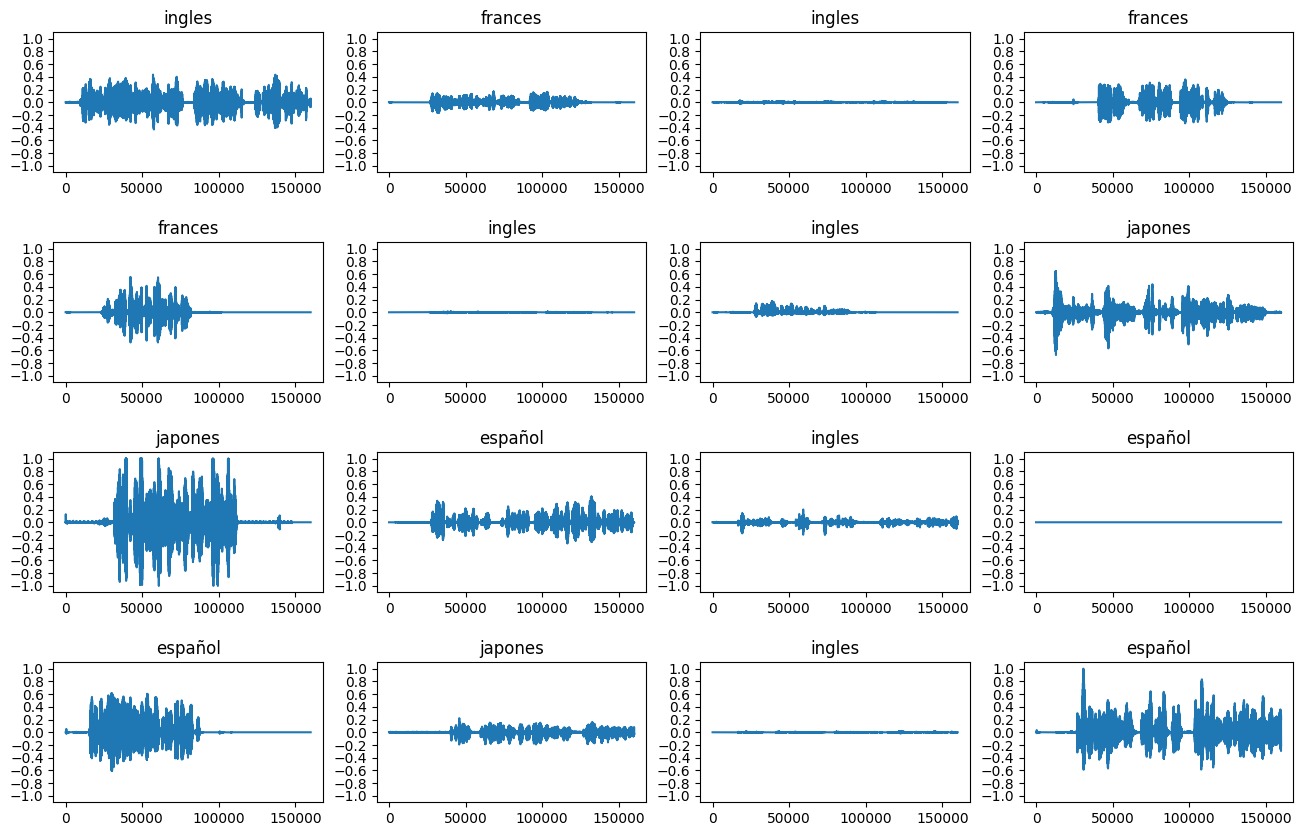

In [26]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 4
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.subplots_adjust(hspace=0.5)
  plt.ylim([-1.1, 1.1])

Al reducir los canales las ondas se vuelven mas "simples" en algunos clips hasta parece no haber sonido.Sin embargo, el volumen puede ser no relevante por lo que seguiremos por convertirlas en espectogramas y observar el cambio de frecuencias a través del tiempo. Y poder entrar a nuestro modelo con esas imagenes representadas en 2D.

# Espectogramas


In [27]:
def get_spectrogram(waveform):
  ''' Params:
      - waveform: los clips de los audios de la misma longitud. (nuestro dataset fue armado así)'''
  # STFT a diferencia de fft splitea la señal en ventans de timepo y calcula la transformadad de fourier para cada una, preservando algo del tiempo.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128) # el frame_length y el frame_step deben ser de forma tal que la "imagen" del espectograma sea casi cuadrada para que ...
  spectrogram = tf.abs(spectrogram) # magnitud del spectograma
  # Agrego una dimension de "canales" para que el se pueda usar la imagen del espectograma como input en las redes convolucionales
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [28]:
label_names[example_labels]

array(['ingles', 'frances', 'ingles', 'frances', 'frances', 'ingles',
       'ingles', 'japones', 'japones', 'español', 'ingles', 'español',
       'español', 'japones', 'ingles', 'español', 'ingles', 'español',
       'español', 'japones', 'japones', 'ingles', 'ingles', 'ingles',
       'español', 'frances', 'japones', 'español', 'frances', 'japones',
       'ingles', 'japones', 'español', 'frances', 'frances', 'frances',
       'frances', 'ingles', 'japones', 'frances', 'ingles', 'frances',
       'ingles', 'japones', 'español', 'japones', 'japones', 'frances',
       'ingles', 'frances', 'español', 'español', 'ingles', 'ingles',
       'frances', 'japones', 'frances', 'español', 'frances', 'ingles',
       'frances', 'español', 'español', 'español'], dtype='<U7')

In [29]:
clean_test=[]
i = 0
while len(clean_test) < 4:
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  # Si ya mostré un audio, entonces sigo buscando uno distinto
  if label not in clean_test:
    clean_test.append(label)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=20000)) # rate es la velocidad mientras mas chico, mas lento.
  else:
    pass
  i += 1

Label: ingles
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: frances
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: japones
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: español
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Graficamos

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  if ax == None:
    ax = plt.gca()
  ax.pcolormesh(X, Y, log_spec)

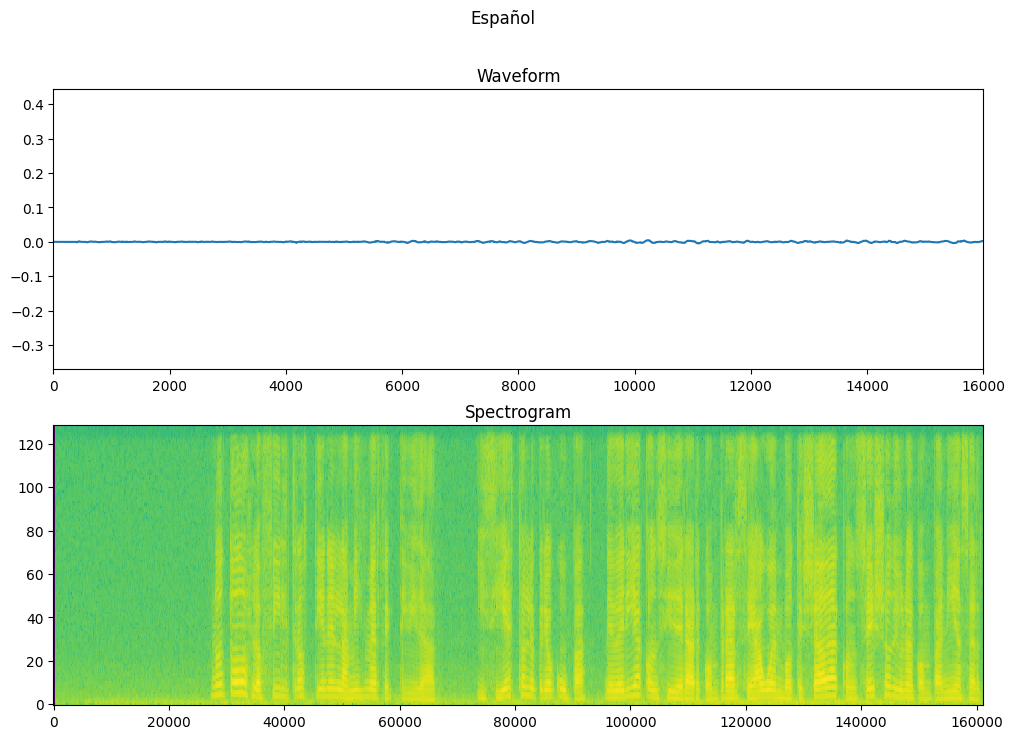

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Armamos nuestro dataset de espectogramas


In [32]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [34]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  # Decode the spect_labels
  print(example_spect_labels.shape)
  print(example_spect_labels)
  break

(64,)
tf.Tensor(
[2 0 2 1 0 3 1 1 1 1 3 0 2 1 1 3 2 2 1 3 3 0 1 0 0 0 0 3 1 2 2 3 3 2 2 0 1
 3 1 1 3 3 3 0 1 3 2 0 1 3 1 2 2 0 0 3 3 2 3 2 2 1 2 1], shape=(64,), dtype=int32)


# Waveform y Espectograma


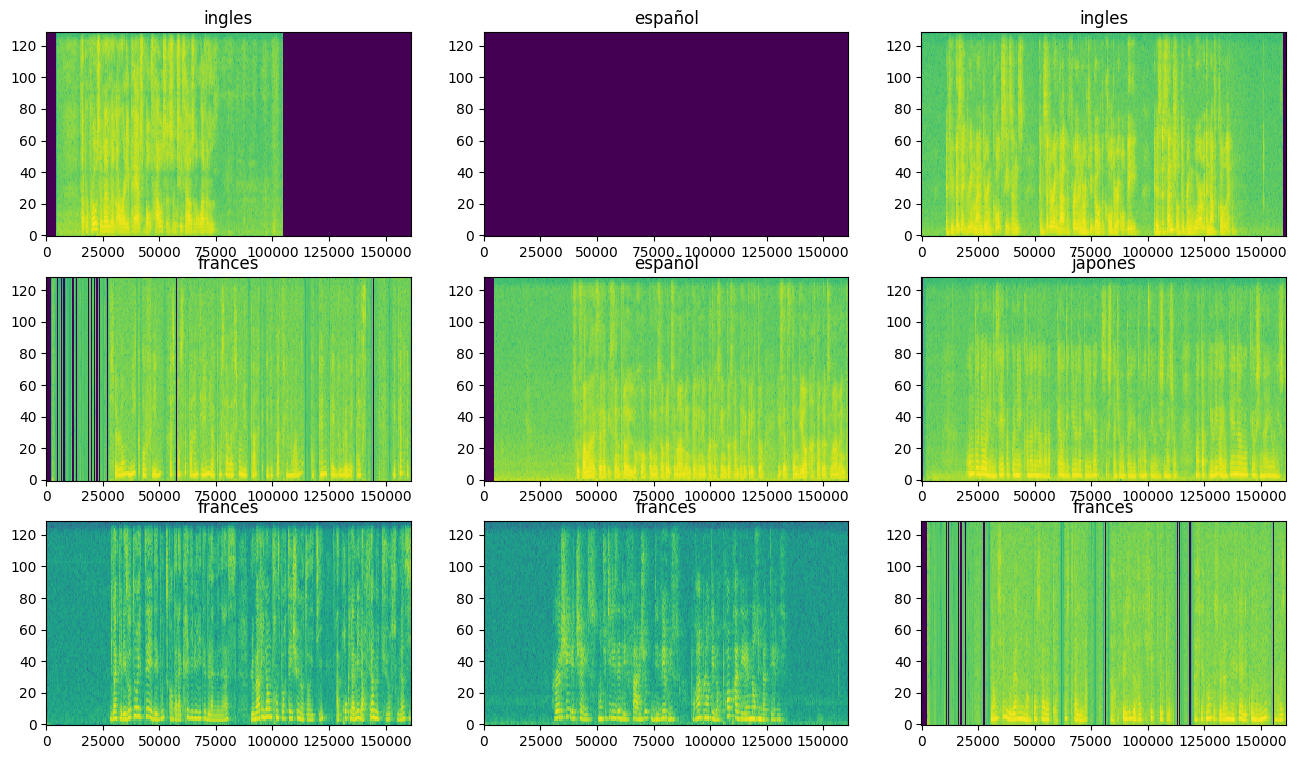

In [35]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


# Modelo Convolucional

In [36]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [37]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1249, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)          

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [39]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
190/190 [==============================] - 10s 46ms/step - loss: 1.1204 - accuracy: 0.5068 - val_loss: 0.9449 - val_accuracy: 0.5820
Epoch 2/15
190/190 [==============================] - 7s 36ms/step - loss: 0.9129 - accuracy: 0.6167 - val_loss: 0.7605 - val_accuracy: 0.6868
Epoch 3/15
190/190 [==============================] - 7s 35ms/step - loss: 0.7773 - accuracy: 0.6786 - val_loss: 0.7290 - val_accuracy: 0.7016
Epoch 4/15
190/190 [==============================] - 7s 36ms/step - loss: 0.6761 - accuracy: 0.7213 - val_loss: 0.5857 - val_accuracy: 0.7628
Epoch 5/15
190/190 [==============================] - 7s 35ms/step - loss: 0.5994 - accuracy: 0.7525 - val_loss: 0.5165 - val_accuracy: 0.7836
Epoch 6/15
190/190 [==============================] - 7s 35ms/step - loss: 0.5350 - accuracy: 0.7847 - val_loss: 0.4668 - val_accuracy: 0.8401
Epoch 7/15
190/190 [==============================] - 7s 35ms/step - loss: 0.4881 - accuracy: 0.8109 - val_loss: 0.4193 - val_accuracy: 0.853

Con las imagenes de los espectrogramas en un modelo convolucional se logra una muy buena accuracy.

# Analisis de las métricas


Text(0, 0.5, 'Accuracy [%]')

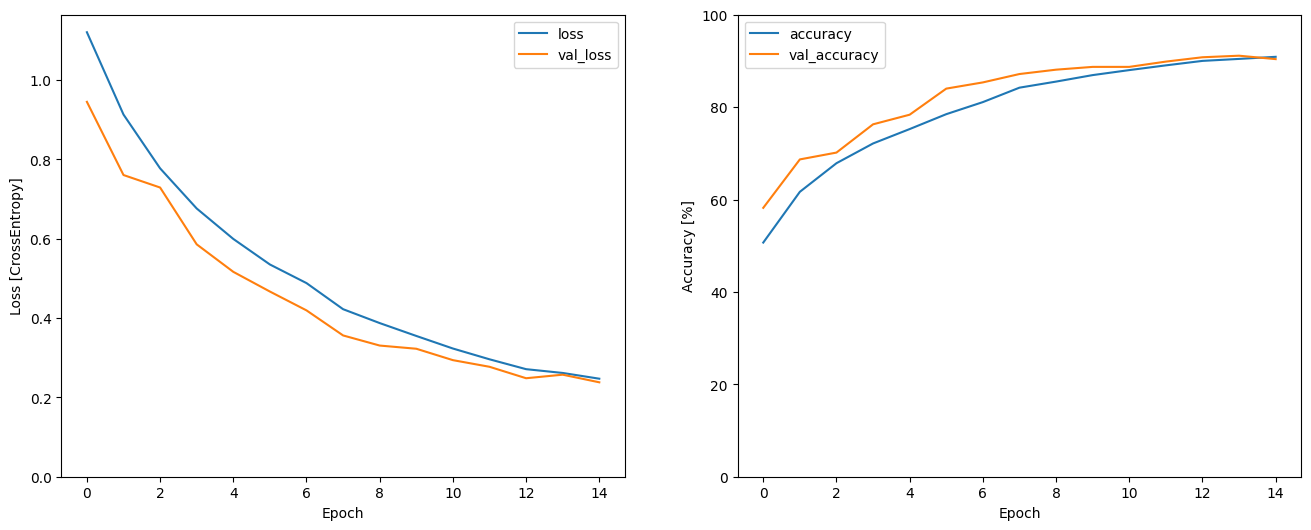

In [40]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

El modelo hace un buen ajuste de los datos el error en validacion en menor que en train y a su vez, el accuracy en validación es mayor en valicación que en test.

In [41]:
model.evaluate(test_spectrogram_ds, return_dict=True)

24/24 [==============================] - 2s 30ms/step - loss: 0.1958 - accuracy: 0.9303


{'loss': 0.19577451050281525, 'accuracy': 0.9303385615348816}

Para los datos no vistos el modelo convolucional tiene un accuracy de 93%

In [42]:
y_pred = model.predict(test_spectrogram_ds)

24/24 [==============================] - 0s 9ms/step


In [43]:
y_pred = tf.argmax(y_pred, axis=1)

In [44]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

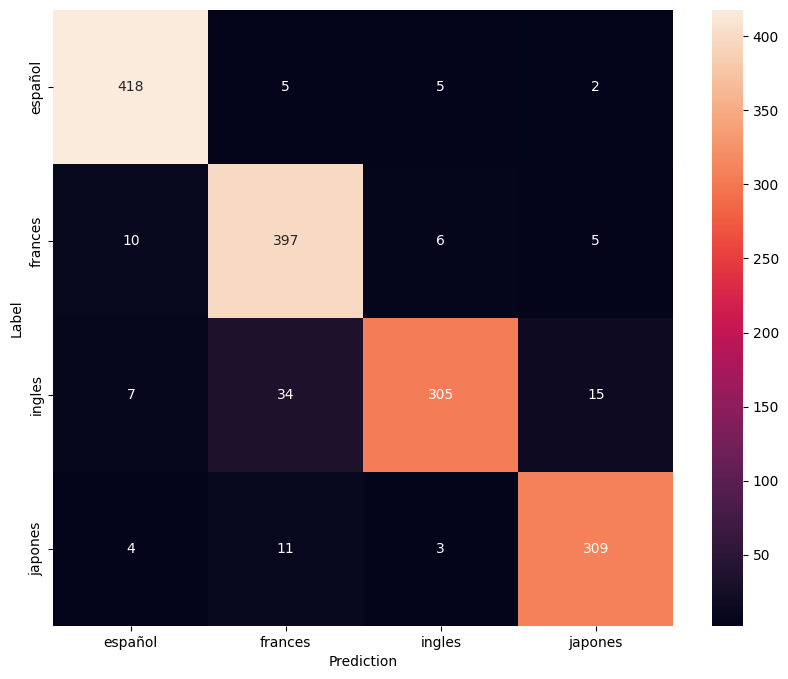

In [45]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

     español       0.95      0.97      0.96       430
     frances       0.89      0.95      0.92       418
      ingles       0.96      0.84      0.90       361
     japones       0.93      0.94      0.94       327

    accuracy                           0.93      1536
   macro avg       0.93      0.93      0.93      1536
weighted avg       0.93      0.93      0.93      1536



### Conclusión del modelo convolucional en test de validación:

Logra una muy buena performance para todas las clases. En general tiene un accuracy del 93%. La clase con la que mayor precisión predice es la de español y tambien la que mejor sabe identificar (recall mas alto). Si bien el modelo tiene una ligera variabilidad en el desempeño entre los idiomas, se destaca para las instancias de japonés (con un f1-score de 0.90) y español (0.94). Tiene un rendimiento algo inferior en inglés (0.84), donde la diferencia en recall (0.86) y precisión (0.94) es más notable.

Segun la matriz de confusión, las instancias de español tampoco las confunde con las de japones. Confunde tambien las instancias de ingles con las de frances.


# Modelo Recurrente

Para el modelo recurrente, crearemos un nuevo dataset en base al dataset de los esptrogramas creados anteriormente. Por cada esptrograma tomaremos recortes y crearemos un array con cada uno de ellos para luego analizarlos con TimeDistributedSequence y encontrar relaciones temporales.

In [47]:
img_height, img_width = 640, 640
segment_length = 10  # Número de frames a extraer por segmento
segment_stride = 5  # Desplazamiento entre segmentos

# Hipotesis inicial

In [ ]:
# Create a normalization layer to scale input data
normalizer = tf.keras.layers.Normalization()

# Compute the statistics (mean, std) over your dataset
normalizer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))


In [48]:
my_old_spec = example_spectrograms[0].numpy()
new_partitioned, label = [], []

segmento = (len(my_old_spec) - segment_length) // segment_stride + 1
for seg in range(segmento):
    start = seg * segment_stride
    end = start + segment_length
    segment = my_old_spec[start:end]
    if len(segment) == segment_length:
        new_partitioned.append(segment)
        label.append(example_spect_labels[0].numpy())

In [49]:
def generate_cuts(spectrogram, num_cuts, overlap):

  spectrogram_length = len(spectrogram)
  cut_length = spectrogram_length // num_cuts
  cuts = []
  for i in range(num_cuts):
    start = i * (cut_length - overlap)
    end = start + cut_length
    # Handle potential out-of-bounds issues
    if end > spectrogram_length:
      end = spectrogram_length
      start = end - cut_length
    cut = spectrogram[start:end]
    cuts.append(cut)


  return np.array(cuts)

# Example usage with your existing code:
my_old_spec = example_spectrograms[0]
my_ol_spect = tf.image.resize(my_old_spec, [640, 640])
cuts = generate_cuts(my_ol_spect.numpy(), 10, 1)
len(cuts)

10

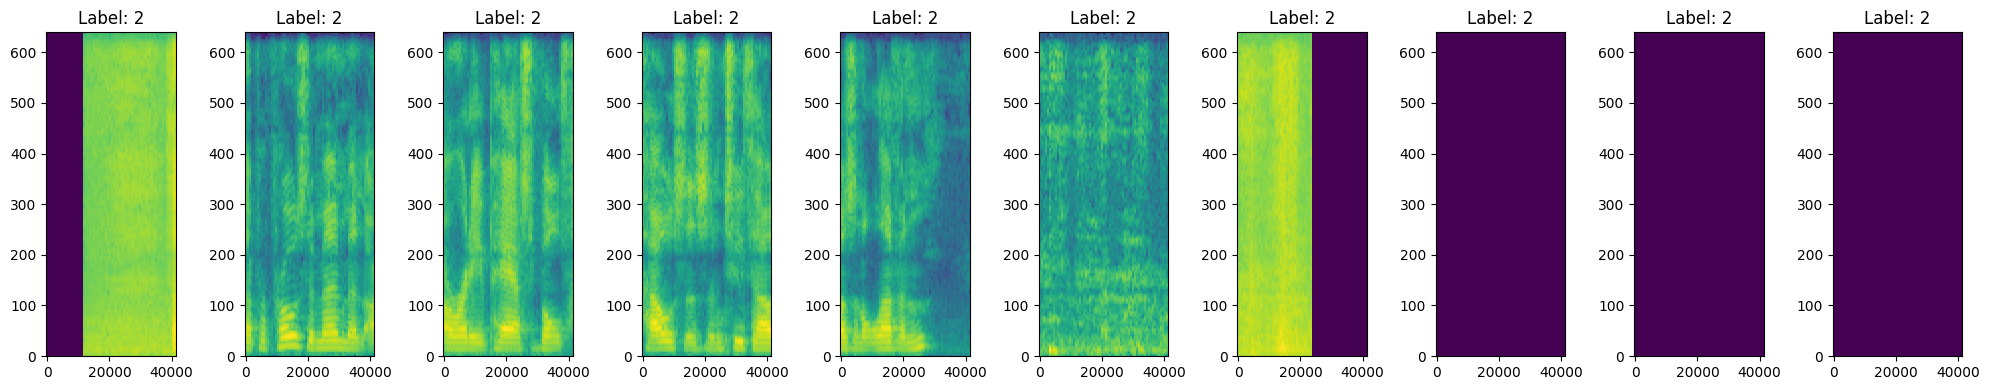

(10, 64, 640, 3)
(248,)


In [50]:
# Plotting each cut
fig, axes = plt.subplots(1, len(cuts), figsize=(20, 4))  # Adjust figsize as needed
X_sim = []
for i, cut in enumerate(cuts):
    # Assuming plot_spectrogram is defined from the previous code
    plot_spectrogram(cut, axes[i])  # Plot each cut in a separate subplot
    axes[i].set_title(f"Label: {label[i]}")
    # Turn it into rgb
    cut = tf.convert_to_tensor(cut)
    cut = tf.image.grayscale_to_rgb(cut)
    X_sim.append(cut)

plt.tight_layout()
plt.show()
print(np.array(X_sim).shape)
print(np.array(label).shape)


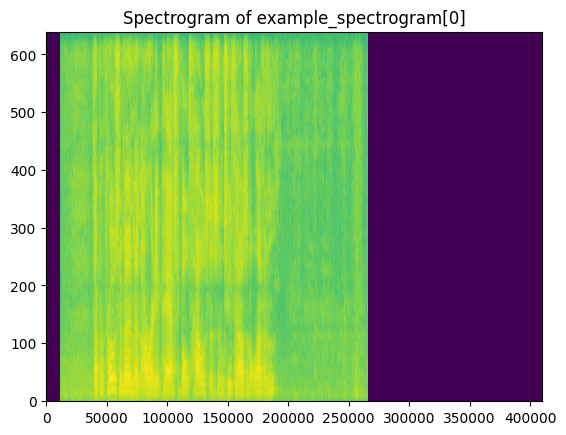

In [51]:
fig, ax = plt.subplots() # Creating a single subplot
plot_spectrogram(my_ol_spect.numpy(), ax=ax)  # Pass the Axes object to plot_spectrogram
plt.title('Spectrogram of example_spectrogram[0]')
plt.show()

Esos serían los segmentos de nuestro espectrograma a representar


# Carga de data set para recurrentes

In [155]:
img_height, img_width = 50, 50
segment_length = 10

In [53]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [182]:
def load_video_classification_dataset(spect_ds, img_height, img_width, segment_length, segment_stride):
    X, y = [], []

    for audio_batch, label_batch in spect_ds:

        # itero por cada audio y etiqueta dentro de mi batch
        for i in range(audio_batch.shape[0]):
            audio = audio_batch[i].numpy()
            label = label_batch[i].numpy()

            num_segments = (audio.shape[0] - segment_length) // segment_stride + 1
            segments = []
            for j in range(min(num_segments, segment_length)):  # Ensure no more than 10 segments are generated
                start = j * segment_stride
                end = start + segment_length

                # spliteo el segment
                segment = audio[start:end, :, :]  # (segment_length, height, width)

                # Resize
                segment_resized = tf.image.resize(segment, [img_height, img_width])  # Resize to (50, 50)

                # RGB para tener los 3 canales (50, 50, 3)
                segment_rgb = tf.image.grayscale_to_rgb(segment_resized)
                segments.append(segment_rgb.numpy())  # Convert to numpy array for storage

            while len(segments) < 10:
                segments.append(np.zeros((img_height, img_width, 3)))  # Agrego vacíos si llego a no tener menos de 10

            X.append(np.array(segments))
            y.append(label)


    X = np.array(X)
    y = np.array(y)
    y = to_categorical(y, num_labels)

    return X, y


In [168]:
X_train, y_train = load_video_classification_dataset(train_spectrogram_ds, img_height, img_width, segment_length, segment_stride)

In [169]:
X_val, y_val = load_video_classification_dataset(val_spectrogram_ds, img_height, img_width, segment_length, segment_stride)

In [170]:
X_test,y_test = load_video_classification_dataset(test_spectrogram_ds, img_height, img_width, segment_length, segment_stride)

In [172]:
X_train.shape # tiene que ser de la forma (num, 10, 50, 50, 3)

(12097, 10, 50, 50, 3)

In [173]:
y_train.shape

(12097, 4)

In [163]:
X_train[0].shape

(10, 50, 50, 3)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, LSTM, Dense

In [174]:
model_rnn = Sequential()
# Capas convolucionales dentro de TimeDistributed
model_rnn.add(TimeDistributed(Conv2D(32, (2, 2), strides=(1,1),activation='relu'), input_shape=(segment_length, img_height, img_width, 3 )))
model_rnn.add(TimeDistributed(MaxPooling2D((2,2))))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(Flatten()))
model_rnn.add(TimeDistributed(Dropout(0.5)))
# Capa recurrente
model_rnn.add(LSTM(32, return_sequences=False, dropout=0.5))
# Capas de salida
#model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(num_labels, activation='softmax'))
# Resumen del modelo
model_rnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeD  (None, 10, 49, 49, 32)    416       
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, 10, 24, 24, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_47 (TimeD  (None, 10, 24, 24, 32)    128       
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, 10, 18432)         0         
 istributed)                                                     
                                                                 
 time_distributed_49 (TimeD  (None, 10, 18432)       

In [146]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [175]:
# Compilar el modelo
model_rnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo con callbacks
history = model_rnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
379/379 [==============================] - 45s 112ms/step - loss: 1.1623 - accuracy: 0.4734 - val_loss: 1.5490 - val_accuracy: 0.3011
Epoch 2/10
379/379 [==============================] - 41s 108ms/step - loss: 0.9653 - accuracy: 0.5741 - val_loss: 1.2330 - val_accuracy: 0.3656
Epoch 3/10
379/379 [==============================] - 41s 109ms/step - loss: 0.8388 - accuracy: 0.6395 - val_loss: 1.2774 - val_accuracy: 0.4308
Epoch 4/10
379/379 [==============================] - 41s 108ms/step - loss: 0.7480 - accuracy: 0.6818 - val_loss: 1.7972 - val_accuracy: 0.3374
Epoch 5/10
379/379 [==============================] - 41s 109ms/step - loss: 0.7373 - accuracy: 0.6836 - val_loss: 0.9438 - val_accuracy: 0.6028
Epoch 6/10
379/379 [==============================] - 41s 108ms/step - loss: 0.6624 - accuracy: 0.7198 - val_loss: 1.0212 - val_accuracy: 0.5491
Epoch 7/10
379/379 [==============================] - 41s 109ms/step - loss: 0.6417 - accuracy: 0.7275 - val_loss: 0.7535 - val_ac

El modelo hace overfitting, una hipotesis puede ser el desbalanceo de las clases.

In [177]:
# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = model_rnn.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

47/47 [==============================] - 2s 36ms/step - loss: 0.7438 - accuracy: 0.6552
Validation Accuracy: 0.6552


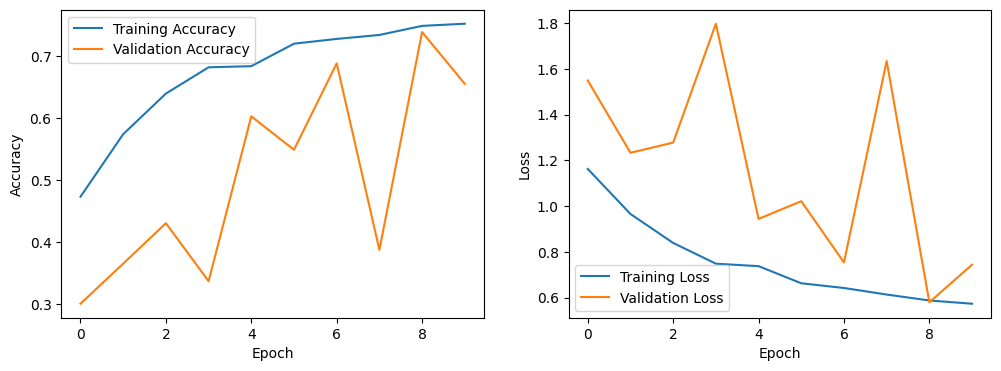

In [178]:
# Visualización de la precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [183]:
# Realizar predicciones en el conjunto de validación
y_pred = model_rnn.predict(X_test)

# Convertir predicciones y etiquetas verdaderas a las clases con mayor probabilidad
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular y mostrar la precisión por clase
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))
label_names

48/48 [==============================] - 2s 36ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.52      0.66       430
           1       0.50      0.98      0.66       418
           2       0.86      0.46      0.60       361
           3       0.86      0.71      0.78       327

    accuracy                           0.67      1536
   macro avg       0.78      0.67      0.67      1536
weighted avg       0.77      0.67      0.67      1536



array(['español', 'frances', 'ingles', 'japones'], dtype='<U7')

El modelo recurrente logra un accuracy del 67%.

Es preciso para las instancias de español, no logra identificar bien las instancias de ingles (0.46) mientras que si sabe reconocer las de frances.

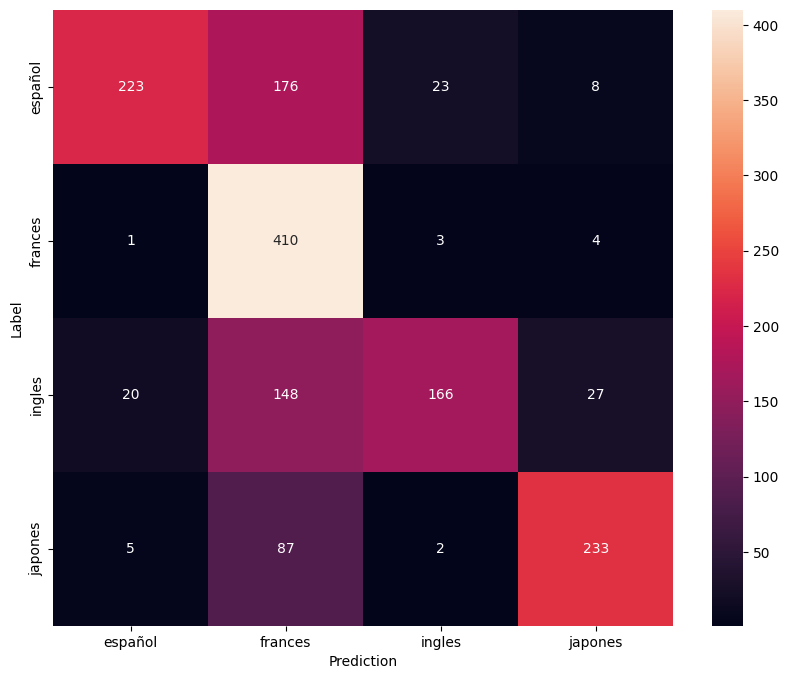

In [181]:
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo tiende a confundir en general las instancias de los demas idiomas con las de frances, una sospecha es que al ser la clase con mas datos de train el modelo puede aprender caracteristicas de esta y agregar ruido sobre las clasificación de las demas.

#Conclusión


El modelo de redes convolucionales tiene una mejor performance, con un accuracy general del 93% contra 62% que logran las redes recurrentes.

El modelo convolucional tampoco se ve afectado por el desbalanceo de las clases mientras que esto es un factor determinante para el modelo recurrente.

Para este tipo de datos (imagenes de los espectrogramas), las redes convolucionales captan mejor los patrones espaciales y locales para cada idioma y además son mas eficientes (requirieron menor tiempo de cómputo)